### Dependencies

In [1]:
from main import *
from stream_processing import *
from event_detection import *

from stream_processing import *
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import torch
import sys
from report_asset_generation import *
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import torch
import sys
from earthquake import Earthquake
from obspy import read
from IPython.display import Image, display
from email_sending import *
from station import Station
from catalog import Catalog
from report import Report, plot_catalogue

### Station Stream Download

In [2]:
station = Station('AM', 'R50D6', 'https://data.raspberryshake.org', "2024-06-01")
print(station)

Station AM.R50D6 at https://data.raspberryshake.org
Location: 54.76576576576576, -1.561623996769607
Report Date: 2024-06-01
Data Folder: D:\Dissertation\data\AM.R50D6\2024-06-01
Report Folder: D:\Dissertation\data\AM.R50D6\2024-06-01\report



Data for 2024-06-01 already exists.
1 Trace(s) in Stream:
AM.R50D6.00.EHZ | 2024-05-31T23:00:00.004000Z - 2024-06-02T01:00:00.004000Z | 100.0 Hz, 9360001 samples


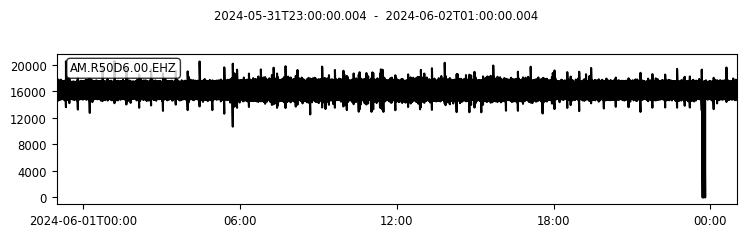

In [7]:
# Download stream and save to file
station.download_stream_data(overwrite=False)

print(station.original_stream)
station.original_stream.plot();


### Stream Signal Cleaning

Demean, Detrend, Outlier Removal And Bandpass Filtering

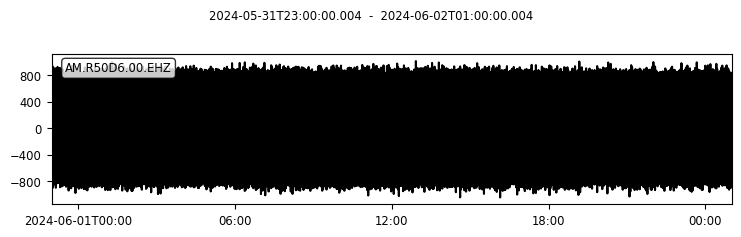

In [5]:
station.processed_stream = process_stream(station.original_stream)
station.processed_stream.plot();

Denoise Using Pretrained DeepDenoiser Model

CUDA available. Denosing using GPU


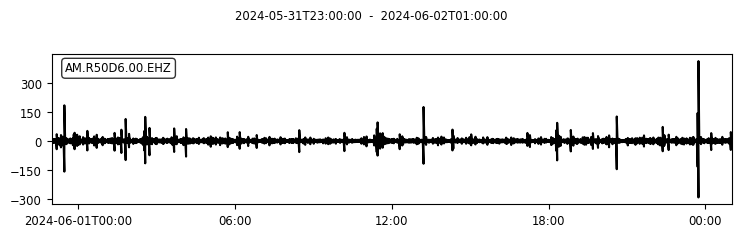

Stream saved to D:\Dissertation\data\AM.R50D6\2024-06-01\2024-06-01_AM.R50D6..Z.processed.mseed


1 Trace(s) in Stream:
AM.R50D6.00.EHZ | 2024-05-31T23:00:00.000000Z - 2024-06-02T01:00:00.000000Z | 100.0 Hz, 9360001 samples

In [8]:
# Denoising the stream 
station.processed_stream = denoise_stream(station.processed_stream)

# Showing denoised stream
station.processed_stream.plot();

# Save processed stream to file
save_stream(station, station.processed_stream, "processed")

### Identify Events From Stream

Pre-trained Phase Picking Model

In [9]:
# Detect P and S waves from stream
station.picked_signals, station.annotated_stream = predict_and_annotate(station.processed_stream)

p_only=True

# Filter by confidence threshold
p_threshold = 0.7 
s_threshold = 1
station.picked_signals = filter_confidence(station.picked_signals, p_threshold, s_threshold)

# Save Picked Phases And Annotated Stream To Files
save_stream(station, station.annotated_stream, "processed.annotated")

# Show results
station.picked_signals

CUDA available. Denosing using GPU
Stream saved to D:\Dissertation\data\AM.R50D6\2024-06-01\2024-06-01_AM.R50D6..Z.processed.annotated.mseed


[{'peak_time': 2024-05-31T23:01:19.020000Z,
  'peak_confidence': 0.7210717,
  'phase': 'P'},
 {'peak_time': 2024-05-31T23:09:51.990000Z,
  'peak_confidence': 0.87537104,
  'phase': 'P'},
 {'peak_time': 2024-05-31T23:13:26.050000Z,
  'peak_confidence': 0.82748175,
  'phase': 'P'},
 {'peak_time': 2024-05-31T23:20:06.000000Z,
  'peak_confidence': 0.846717,
  'phase': 'P'},
 {'peak_time': 2024-05-31T23:22:00.800000Z,
  'peak_confidence': 0.7438513,
  'phase': 'P'},
 {'peak_time': 2024-05-31T23:34:03.920000Z,
  'peak_confidence': 0.7849723,
  'phase': 'P'},
 {'peak_time': 2024-05-31T23:34:53.090000Z,
  'peak_confidence': 0.8210529,
  'phase': 'P'},
 {'peak_time': 2024-05-31T23:35:49.030000Z,
  'peak_confidence': 0.7713356,
  'phase': 'P'},
 {'peak_time': 2024-05-31T23:39:19.950000Z,
  'peak_confidence': 0.7803461,
  'phase': 'P'},
 {'peak_time': 2024-05-31T23:48:39.940000Z,
  'peak_confidence': 0.7710779,
  'phase': 'P'},
 {'peak_time': 2024-05-31T23:57:06.000000Z,
  'peak_confidence': 0.78

In [10]:
print(station.original_stream)
print(station.processed_stream)
print(station.annotated_stream)

1 Trace(s) in Stream:
AM.R50D6.00.EHZ | 2024-05-31T23:00:00.004000Z - 2024-06-02T01:00:00.004000Z | 100.0 Hz, 9360001 samples
1 Trace(s) in Stream:
AM.R50D6.00.EHZ | 2024-05-31T23:00:00.000000Z - 2024-06-02T01:00:00.000000Z | 100.0 Hz, 9360001 samples
3 Trace(s) in Stream:
AM.R50D6.00._Detection | 2024-05-31T23:00:05.000000Z - 2024-06-02T00:59:55.000000Z | 100.0 Hz, 9359001 samples
AM.R50D6.00._P         | 2024-05-31T23:00:05.000000Z - 2024-06-02T00:59:55.000000Z | 100.0 Hz, 9359001 samples
AM.R50D6.00._S         | 2024-05-31T23:00:05.000000Z - 2024-06-02T00:59:55.000000Z | 100.0 Hz, 9359001 samples


### Request Catalog

In [15]:
# Initiate a new Catalog object
catalog = Catalog(station, radmin=0, radmax=90, minmag=4, maxmag=10)

# Specify multiple providers as fallback options
providers = [ "IRIS", "USGS", "EMSC"]

# Download catalog
catalog.request_catalogue(providers)

### Catalog Events Processing

In [16]:
if catalog.events:
    catalog.process_catalogue()
    for eq in catalog.earthquakes:
        print(eq)

Earthquake ID: 2024-06-01_01
Provider: IRIS
Provider Event ID: smi:service.iris.edu/fdsnws/event/1/query?eventid=11849484
Time: 2024-06-01T20:32:52.926000Z
Latitude: 9.6163, Longitude: -84.1099
Depth: 53.54 km
Magnitude: 4.1 mb
Epicentral Distance: 8658.198818809235 km
P Predicted: 2024-06-01T20:44:45.041786Z, S Predicted: 2024-06-01T20:54:34.543827Z
P Detected: None, S Detected: None
P Confidence: None, S Confidence: None
P Error: None, S Error: None
Catalogued: Yes, Detected: No
----------------------------------------
Earthquake ID: 2024-06-01_02
Provider: IRIS
Provider Event ID: smi:service.iris.edu/fdsnws/event/1/query?eventid=11850151
Time: 2024-06-01T19:17:55.277000Z
Latitude: 51.1627, Longitude: -178.8859
Depth: 41.325 km
Magnitude: 4.0 mb
Epicentral Distance: 8233.770731788318 km
P Predicted: 2024-06-01T19:29:28.194031Z, S Predicted: 2024-06-01T19:38:59.605197Z
P Detected: None, S Detected: None
P Confidence: None, S Confidence: None
P Error: None, S Error: None
Catalogued: Ye

In [2]:

simplified = False

### Matching And Merging Events From Catalog And Station Stream

In [11]:
# Using a time tolerance as thresholds for matching signals
station.processed_events =  match_and_merge(catalog.earthquakes, station.picked_signals, tolerance_p = 10, tolerance_s = 0, p_only = p_only)

# Add time error values for matched earthquakes
for eq in station.processed_events:
    eq.update_errors()
    
# Save processed list of all events to file
save_list(station.processed_events, station,"completed")

List saved to D:\Dissertation\data\AM.R50D6\2024-06-01\report\2024-06-01.completed.csv


### Results Statistics

In [12]:
stats = calculate_matching_stats(station.processed_events)
print(f"Number of catalogued events: {stats[0]}")
print(f"Number of matched events: {stats[1]}")
print(f"Number of not detected events: {stats[2]}")
print(f"Number of events not in catalogue: {stats[3]}")
print(f"Number of P waves identified: {stats[4]}")
print(f"Number of S waves identified: {stats[5]}")


Number of catalogued events: 16
Number of matched events: 1
Number of not detected events: 15
Number of events not in catalogue: 17
Number of P waves identified: 1
Number of S waves identified: 0


### Report Assets Generation

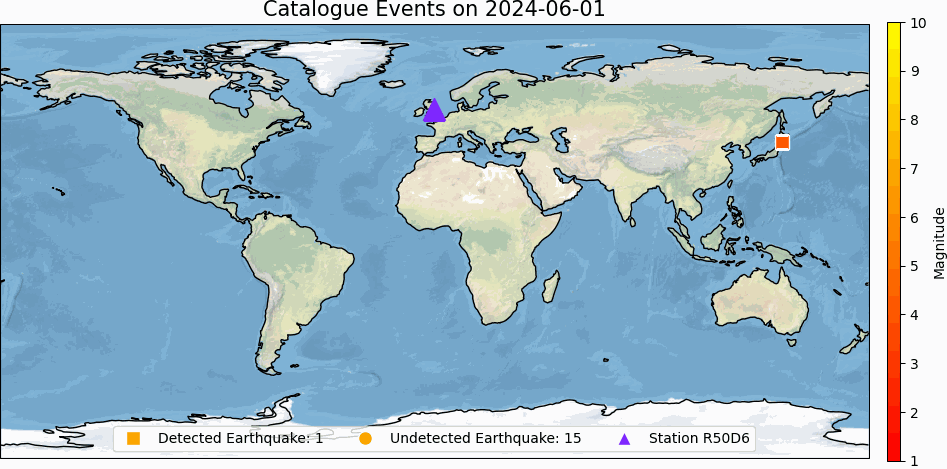

In [13]:

catalogue_plot = plot_catalogue(station, fill_map = True, create_gif=True)
display(Image(filename=catalogue_plot))

Wave+Annotation Plots For Matched Events To File Using Event ID

In [14]:
matched_events = [eq for eq in station.processed_events if eq.catalogued and eq.detected]

for earthquake in matched_events:
    if matched_events:  
        # Generate the plot for each earthquake
        earthquake.generate_plot(read(station.processed_stream), read(station.annotated_stream), path=station.report_folder, simplified = simplified, p_only = p_only)
        
        display(Image(filename=earthquake.plot_path))


No data in the trace.


ValueError: No image data found. Expecting filename, url, or data.

In [ ]:
# Create a new Report object with necessary files and info
report = Report(station, simplified=simplified, p_only=p_only,fill_map = True, create_gif=True)

# Generate image assets and html codes for the email
report.construct_email()

# Send the email
report.send_email('xmpg69@durham.ac.uk')